In [5]:
import pandas as pd
from datetime import datetime
import os

In [6]:
pd.set_option('display.max_colwidth', None)
pd.set_option("display.max_rows", 900)

In [7]:
msg_total=pd.read_csv('../safety_msg_crawling_total.csv',engine='python')

In [8]:
msg_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90148 entries, 0 to 90147
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   create_date    90148 non-null  object
 1   location_id    90148 non-null  object
 2   location_name  90101 non-null  object
 3   md101_sn       90148 non-null  int64 
 4   msg            90147 non-null  object
 5   send_platform  90148 non-null  object
dtypes: int64(1), object(5)
memory usage: 4.1+ MB


In [9]:
msg_total['create_date']=pd.to_datetime(msg_total['create_date'])

In [10]:
msg_total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90148 entries, 0 to 90147
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   create_date    90148 non-null  datetime64[ns]
 1   location_id    90148 non-null  object        
 2   location_name  90101 non-null  object        
 3   md101_sn       90148 non-null  int64         
 4   msg            90147 non-null  object        
 5   send_platform  90148 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 4.1+ MB


In [11]:
msg_total=msg_total[msg_total['create_date']>='2020-01-23 15:08:34']
msg_total.head()

,create_date,location_id,location_name,md101_sn,msg,send_platform
0,2021-07-02 10:24:18,104,대구광역시 전체,110649,[대구광역시] 2일 0시 기준 확진자 9명(동구3 북구2 서구1 수성구1 달서구1 달성군1)발생. 의심시 외출 자제 및 가까운 보건소 예약 후 검사 바랍니다.,cbs
1,2021-07-02 10:22:59,98,광주광역시 전체,110648,"[광주광역시] 6.18.(금)~6.30.(수) 보보스(BOBOS)호프(북구 대자로 72-1, 운암동)에 방문하신 분은 거주지 보건소에서 검사받으시기 바랍니다.",cbs
2,2021-07-02 10:16:02,23,경기도 고양시,110647,"[고양시청]7.1.(목) 일일 확진자 33명(덕양구9,일산동구14,일산서구9,타지역 거주1) ▶타지역확진 고양시민 2명 https://han.gl/iMmgw 참조",cbs
3,2021-07-02 10:11:29,58,경상남도 남해군,110646,[남해군청]▶7.2.(금) 09:00기준 확진자 2명 발생 ( 자가격리 중 해제 전 검사 시 ) ▶관련정보는 남해군 홈페이지 또는 페이스북 참고 바랍니다.,cbs
4,2021-07-02 10:09:23,26,경기도 광주시,110645,"[광주시청]제2차 광주시 재난기본소득(1인당 10만원) 미신청 하신 분은 7월말까지 주소지 읍면동사무소에서 신청바랍니다.(대상: 3.8.기준 광주시민,등록외국인)",cbs


### test_msg_sent: 검사독려

In [12]:
plz_be_tested = msg_total[msg_total["msg"].str.contains("선별진료소") |\
                          msg_total["msg"].str.contains("무기명") |\
                          msg_total["msg"].str.contains("증상") |\
                          msg_total["msg"].str.contains("발현") |\
                          msg_total["msg"].str.contains("의심") |\
                          msg_total["msg"].str.contains("가까운") |\
                          msg_total["msg"].str.contains("발열") |\
                          msg_total["msg"].str.contains("오한") |\
                          msg_total["msg"].str.contains("기침") |\
                          msg_total["msg"].str.contains("두통") |\
                          msg_total["msg"].str.contains("구토") |\
                          msg_total["msg"].str.contains("설사") |\
                          msg_total["msg"].str.contains("1339")
                         ]

In [13]:
plz_be_tested=plz_be_tested.drop(['location_id','location_name','md101_sn','msg','send_platform'],axis=1)
plz_be_tested=plz_be_tested.reset_index(drop=True)
print(len(plz_be_tested))
plz_be_tested.head()

14004


,create_date
0,2021-07-02 10:24:18
1,2021-07-02 10:00:07
2,2021-07-02 09:08:28
3,2021-07-02 08:13:54
4,2021-07-01 18:11:24


In [14]:
test_msg_sent=plz_be_tested.groupby(plz_be_tested['create_date'].dt.date).count()
test_msg_sent.columns=['amount']
test_msg_sent.reset_index(inplace=True)
test_msg_sent['create_date']=pd.to_datetime(test_msg_sent['create_date'])
test_msg_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 526 entries, 0 to 525
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   create_date  526 non-null    datetime64[ns]
 1   amount       526 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.3 KB


In [15]:
test_msg_sent_smoothed=test_msg_sent.rolling(7,min_periods=1).mean()
test_msg_sent_smoothed.index=test_msg_sent['create_date']
test_msg_sent_smoothed.head()

,amount
create_date,
2020-01-23,2.000000
2020-01-24,8.000000
2020-01-25,6.666667
2020-01-26,5.750000
2020-01-27,6.400000


### covid_msg_sent 코로나관련 문자

In [16]:
covid_msg = msg_total[msg_total["msg"].str.contains("선별진료소") |\
                          msg_total["msg"].str.contains("무기명") |\
                          msg_total["msg"].str.contains("증상") |\
                          msg_total["msg"].str.contains("발현") |\
                          msg_total["msg"].str.contains("의심") |\
                          msg_total["msg"].str.contains("가까운") |\
                          msg_total["msg"].str.contains("발열") |\
                          msg_total["msg"].str.contains("오한") |\
                          msg_total["msg"].str.contains("기침") |\
                          msg_total["msg"].str.contains("두통") |\
                          msg_total["msg"].str.contains("구토") |\
                          msg_total["msg"].str.contains("설사") |\
                          msg_total["msg"].str.contains("1339") |\
                          msg_total["msg"].str.contains("이태원") |\
                          msg_total["msg"].str.contains("신천지") |\
                          msg_total["msg"].str.contains("집회") |\
                          msg_total["msg"].str.contains("교회") |\
                          msg_total["msg"].str.contains("백신") |\
                          msg_total["msg"].str.contains("교회") |\
                          msg_total["msg"].str.contains("자제") |\
                          msg_total["msg"].str.contains("동선") |\
                          msg_total["msg"].str.contains("신규") |\
                          msg_total["msg"].str.contains("코로나") |\
                          msg_total["msg"].str.contains("거리두기")
                         ]

In [17]:
covid_msg=covid_msg.drop(['location_id','location_name','md101_sn','msg','send_platform'],axis=1)
covid_msg=covid_msg.reset_index(drop=True)
print(len(covid_msg))
covid_msg.head()

55310


,create_date
0,2021-07-02 10:24:18
1,2021-07-02 10:00:07
2,2021-07-02 09:46:38
3,2021-07-02 09:08:28
4,2021-07-02 08:56:56


In [18]:
covid_msg_sent=covid_msg.groupby(covid_msg['create_date'].dt.date).count()
covid_msg_sent.columns=['amount']
covid_msg_sent.reset_index(inplace=True)
covid_msg_sent['create_date']=pd.to_datetime(covid_msg_sent['create_date'])
covid_msg_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   create_date  527 non-null    datetime64[ns]
 1   amount       527 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.4 KB


In [19]:
covid_msg_sent_smoothed=covid_msg_sent.rolling(7,min_periods=1).mean()
covid_msg_sent_smoothed.index=covid_msg_sent['create_date']
covid_msg_sent_smoothed.head()

,amount
create_date,
2020-01-23,3.0
2020-01-24,8.5
2020-01-25,7.0
2020-01-26,6.0
2020-01-27,6.6


### total_msg 전체 재난문자

In [20]:
msg_total=msg_total.drop(['location_id','location_name','md101_sn','msg','send_platform'],axis=1)
msg_total=msg_total.reset_index(drop=True)
print(len(msg_total))
msg_total.head()

85640


,create_date
0,2021-07-02 10:24:18
1,2021-07-02 10:22:59
2,2021-07-02 10:16:02
3,2021-07-02 10:11:29
4,2021-07-02 10:09:23


In [21]:
total_msg_sent=msg_total.groupby(msg_total['create_date'].dt.date).count()
total_msg_sent.columns=['amount']
total_msg_sent.reset_index(inplace=True)
total_msg_sent['create_date']=pd.to_datetime(total_msg_sent['create_date'])
total_msg_sent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   create_date  527 non-null    datetime64[ns]
 1   amount       527 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.4 KB


In [22]:
total_msg_sent

,create_date,amount
0,2020-01-23,3
1,2020-01-24,14
2,2020-01-25,5
3,2020-01-26,5
4,2020-01-27,10
5,2020-01-28,11
6,2020-01-29,14
7,2020-01-30,29
8,2020-01-31,32
9,2020-02-01,19


In [23]:
total_msg_sent_smoothed=total_msg_sent.rolling(7,min_periods=1).mean()
total_msg_sent_smoothed.index=total_msg_sent['create_date']
total_msg_sent_smoothed.head()

,amount
create_date,
2020-01-23,3.000000
2020-01-24,8.500000
2020-01-25,7.333333
2020-01-26,6.750000
2020-01-27,7.400000


In [24]:
import numpy as np

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks_cwt

In [26]:
peaks=find_peaks_cwt(test_msg_sent_smoothed['amount'].to_numpy(),
                     widths=np.ones(test_msg_sent_smoothed['amount'].to_numpy().shape)*2)
test_msg_sent_smoothed.iloc[peaks]

,amount
create_date,
2020-02-05,22.571429
2020-02-27,88.857143
2020-04-17,15.428571
2020-05-15,31.142857
2020-06-18,9.000000
2020-07-10,13.285714
2020-08-22,85.714286
2020-10-08,23.714286
2020-11-28,47.285714


### 그래프

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks_cwt

### axvspan:축에 수직 스팬(사각형)을 추가한다.

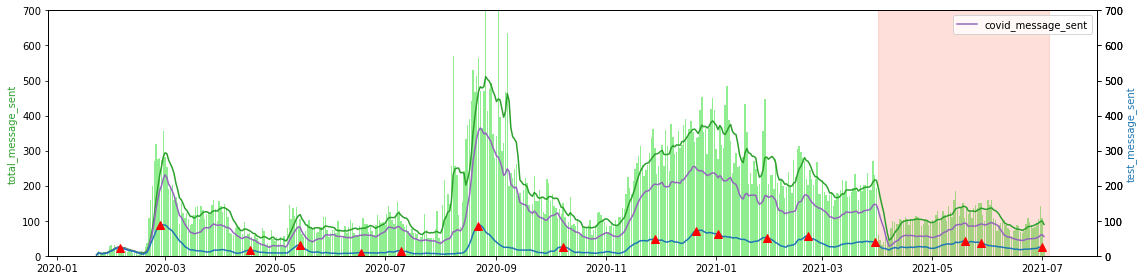

In [42]:
fig,ax1=plt.subplots(figsize=(16,4))
color='tab:green'
ax1.set_ylabel('total_message_sent',color=color)
ax1.plot(total_msg_sent_smoothed,color=color)
ax1.bar(total_msg_sent.create_date, total_msg_sent.amount,color='lightgreen')
ax1.set_ylim(0,700)

ax2=ax1.twinx()
color='tab:purple'
ax2.plot(covid_msg_sent_smoothed,label='covid_message_sent',color=color)
ax2.set_ylim(0,700)
ax2.legend(loc='upper right')

ax3=ax1.twinx()
color='tab:blue'
ax3.set_ylabel('test_message_sent',color=color)
ax3.plot(test_msg_sent_smoothed,color=color)
ax3.plot(test_msg_sent_smoothed.iloc[peaks],'r^',ms=8)
ax3.set_ylim(0,700)

ax1.axvspan('2021-04-01', '2021-07-05', color='tomato', alpha=0.2)

fig.tight_layout()

In [29]:
print('total_msg 갯수는:',len(msg_total))
print('covid_msg 갯수는:',len(covid_msg))
print('test_msg 갯수는:',len(plz_be_tested))

total_msg 갯수는: 85640
covid_msg 갯수는: 55310
test_msg 갯수는: 14004
